# Estimating the lifetime of a Muon

First we must import all our required modules and libraries

In [1]:
# Import standard libraries
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Add project root to Python Path
project_root = Path("..").resolve()
sys.path.append(str(project_root / "src"))

# Import custom modules
from preprocessing import get_data
from preprocessing import remove_anom_pmt
from preprocessing import format_data
from preprocessing import average_decay_by_event
from preprocessing import save_data
from plots import muon_histogram_comp
from plots import log_cutoffs
from plots import naive_bin_result
from plots import pdf_display
from simulation import naive_bins
from simulation import halflife_estimation
from simulation import total_pdf
from simulation import likelihood_profiling
from validation import generate_toy_data

Then we can load our dataset and take our first look at it. 

Note that when using the `.head()` method, the loss of numerical accuracy is purely a visual feature, and the much more precise values are held in memory.

In [2]:
df = get_data()

df.head()

,channel_numb,julian_day,start_decay,end_decay
0,6234.1,2458114,0.501881,0.501881
1,6234.2,2458114,0.501881,0.501881
2,6234.1,2458114,0.503081,0.503081
3,6234.2,2458114,0.503081,0.503081
4,6234.1,2458114,0.503123,0.503123


Next we can inspect the datatypes to see if any are incorrect.

In [3]:
df.dtypes

channel_numb    float64
julian_day        int64
start_decay     float64
end_decay       float64
dtype: object

Although there are no immediate errors, `channel_numb` is simply an identification, so we can update it to an object instead.

In [4]:
df["channel_numb"] = df["channel_numb"].astype(object, copy=False)

We can now look over basic descriptive statistics to identify any possible errors in values.

Although `julian_day` is just a lebel, it is used for future calculations so must remain as an integer. 

In [5]:
df.describe()

,julian_day,start_decay,end_decay
count,8.762000e+03,8762.000000,8762.000000
mean,2.458116e+06,0.507297,0.507297
std,9.731785e-01,0.287299,0.287299
min,2.458114e+06,0.000294,0.000294
25%,2.458115e+06,0.266677,0.266677
50%,2.458116e+06,0.506915,0.506915
75%,2.458116e+06,0.757742,0.757742
max,2.458117e+06,0.999867,0.999867


As our data has passed the basic 'sanity checks', we can start to clean the dataset by removing NaN values.

In [6]:
nan_counts = df.isna().sum()
print(nan_counts)

channel_numb    0
julian_day      0
start_decay     0
end_decay       0
dtype: int64


As there are no NaN values, we can move one and consider any duplicated rows. 

In [7]:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [channel_numb, julian_day, start_decay, end_decay]
Index: []



We can clearly see that all the data is unique. 

Next we must consider any impossible values. According to the data's documentation, all readings are present in the the form M.N, where M is the run, and N is the PMT channel. The later of which should only have values of 1 or 2, depending on the specific PMT used. 

In [8]:
unique_values = df["channel_numb"].unique()
print(f"Unique values of {"channel_numb"}: {unique_values}")

Unique values of channel_numb: [6234.1 6234.2 6234.4]


Now we can see that there are some irregular channel numbers as 6234.4 should not exist, so we can remove these without further consideration. 

In [9]:
df = remove_anom_pmt(df)

unique_values = df["channel_numb"].unique()
print(f"Unique values of 'channel_numb': {unique_values}")

Unique values of 'channel_numb': [6234.1 6234.2 6234.4]


Now we can see that all erroneous data values have been removed. 

Now that the data has been cleaned, we can complete some basic feature engineering and convert times from unusuable fractions of a Julian day into more standard time units, and calculate the possible decay time. 

In [10]:

df = format_data(df)
df.head()

,channel_numb,julian_day,start_decay,end_decay,decay_time
0,6234.1,0,43362.555429,43362.555435,6.541246
1,6234.2,0,43362.555429,43362.555435,6.540002
2,6234.1,0,43466.182883,43466.182884,1.371249
3,6234.2,0,43466.182883,43466.182884,1.370005
4,6234.1,0,43469.835603,43469.835605,2.560017


Although it may initially appear that data is now cleaned, when examined more thoroughly we see that each decay is detected by both PMts, meaning that these results should be aggregated to reduce noise. Furthermore, some PMTs fire twice leading to erroneous results, as can be shown at index 18 when compared to the pairs of decays at indices 16, 17 and 19, 20.

In [11]:
df[16:21]

,channel_numb,julian_day,start_decay,end_decay,decay_time
16,6234.1,0,43707.674905,43707.674906,1.190005
17,6234.2,0,43707.674905,43707.674906,1.193752
18,6234.1,0,43707.674905,43707.674906,1.168773
19,6234.1,0,43752.625580,43752.625581,0.950000
20,6234.2,0,43752.625580,43752.625581,0.950000


Events recorded by different detectors were associated using a coincidence window, $\Delta t$, accounting for digitisation and clock jitter. Measurements within each coincidence group were cleaned using a median-based outlier rejection before averaging to reduce detector noise.

In [12]:
df_old = df.copy()
df = average_decay_by_event(df)

Now we can observe the noise reduction by comparing the distributions of decay time. 

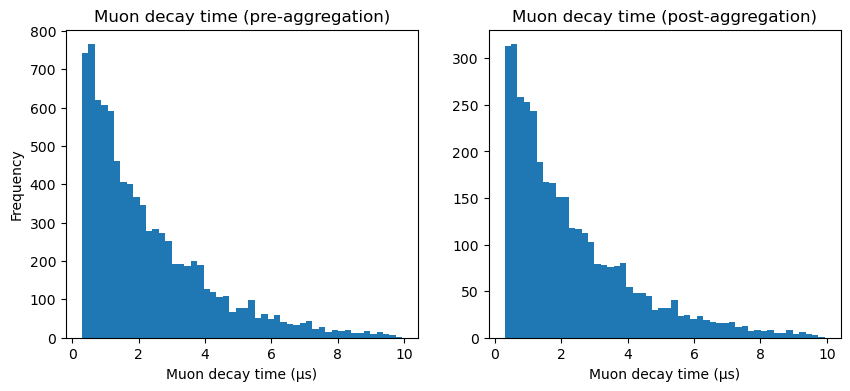

In [13]:

muon_histogram_comp(df_old, df)

This final dataframe can be saved so that it can be more easily processed by future endeavors

In [14]:
# If the data needs to be saved, then uncomment the following line and run:

#save_data(df)

The next step is to decide the minimum and maximum possible decay times - removing any potential artefacts of the detectors. As muon decay is a poisson process, we expect the plot to be exponential, meaning that if a log plot was taken, we can simply identify the regions where the plot is approximately linear. 

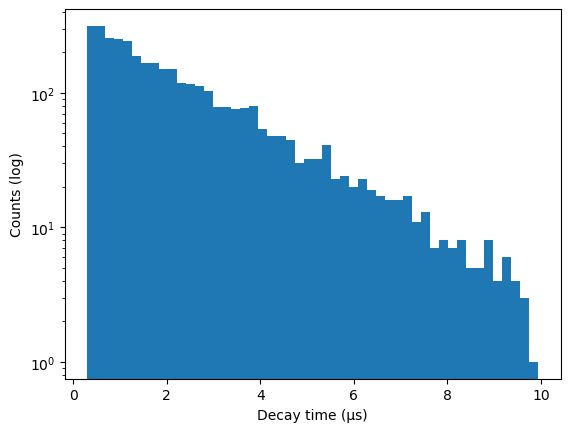

In [15]:
plt.hist(df["decay_time"], bins=50)
plt.yscale("log")
plt.xlabel("Decay time (µs)")
plt.ylabel("Counts (log)")
plt.show()

First, the minimum time can be assessed. It can be observed that below a certain time there is a spike in frequency around the t=0 mark, which can be found to be approximately at t=0.7

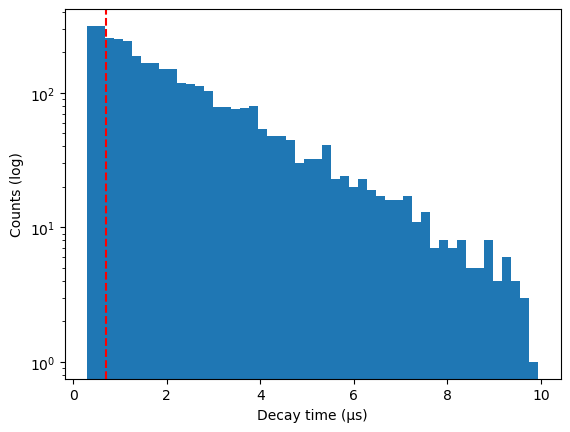

In [16]:
t_min = 0.7
log_cutoffs(df, x_line=t_min)

Next, the same can be applied to find the upper time, where after t=7.6 the frequency appears to decrease more rapidly.

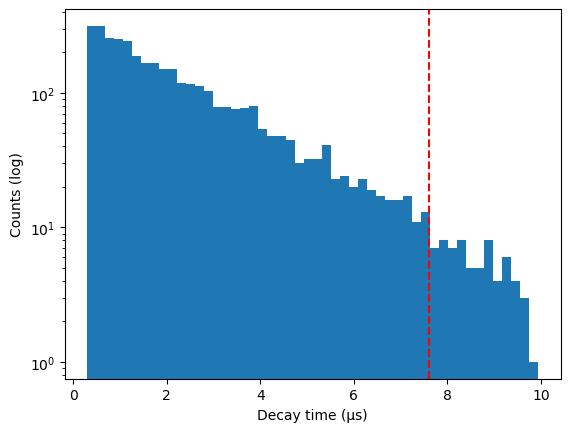

In [17]:
t_max = 7.6
log_cutoffs(df, x_line=t_max)

For ease and numerical efficiency, we can simply take a single numpy array of the data. 

In [18]:
t_sel  = df["decay_time"][(df["decay_time"] > t_min) & (df["decay_time"] < t_max)]

To confirm that we have a nice exponential, we can observe the data again.

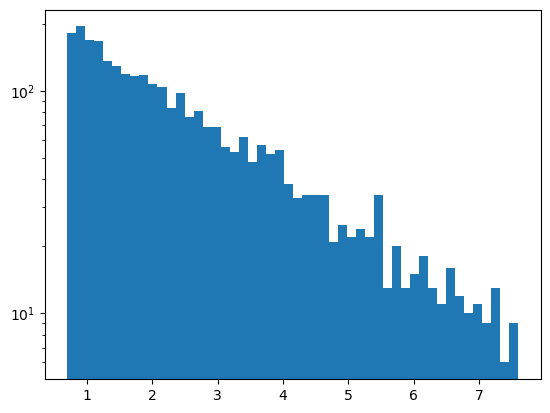

In [19]:
plt.hist(t_sel, bins=50)
plt.yscale("log")
plt.show()

The lower time cut $t_{min}$⁡ was chosen to exclude early-time distortions due to detector resolution and trigger effects, identified empirically as deviations from exponential behaviour on a log-scale histogram. The upper time cut $t_{max⁡}$ was chosen to avoid bias from the finite acquisition window, visible as a truncation at large decay times.

We can now attempt to model muon decays using a naïve binning model that uses least squares regression to fit the data to a pure exponential: 

$N(t) = A e^{-t/\tau}$



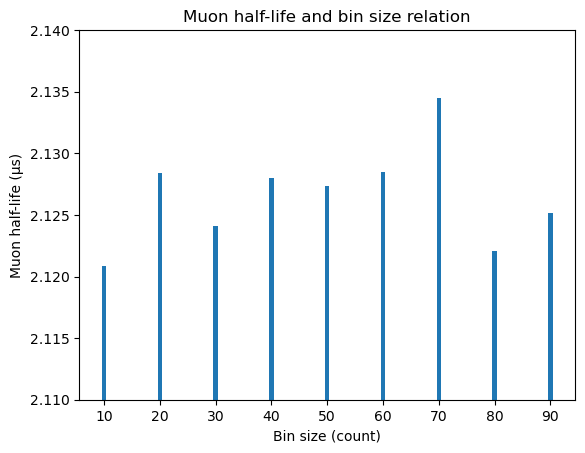

In [20]:
bin_list = np.arange(10, 100, 10)
taus = naive_bins(bin_list, t_sel, t_min, t_max)
naive_bin_result(bin_list, taus, 2.11, 2.14)

From this we can see that just by varying the number of bins, we can hugely impact our results, with no distinct pattern. It is clear that we will need a better, more statistically robust, approach. 

## Analysis

Let us first assess the mathematical nature of the data:

$$\{t_i​\},\space i=1,…,N$$

Where:
- Each $t_i$ is a single robust muon decay
- data are independent 
- the only events that are observed are in the interval $(t_{min}, t_{max})$

Muon decay is a Markovian process meaning the probability that a muon decays in the next $dt$ is independent of how long it has already lived. This gives rise to the Poisson nature of muon decay and the exponential decay law:

$$f(t∣\tau)=\tfrac{1}{\tau} e^{−t/\tau},\space t≥0$$

Where:
- t = decay time
- $\tau$ = mean muon lifetime

However, one key detail is that the data does not follow that regular exponential distribution, it actually follows the exponential distribution conditioned on the event falling inside the observable window.

$$f(t|t_{min}<t<t_{max}, \tau) = \dfrac{f(t|\tau)}{P(t_{min}<t<t_{max}|\tau)}$$

We can now compute the normalisation process:

$$P(t_{min}<t<t_{max}|\tau) = \int_{t_{min}}^{t_{max}}\dfrac{1}{\tau}e^{-t/\tau} = e^{-t_{max}/\tau} - e^{-t_{min}/\tau}$$

The final truncated PDF of the signal is given by:

$$f_{sig}(t|\tau) = \dfrac{\tfrac{1}{\tau}e^{-t/\tau}}{e^{-t_{max}/\tau} - e^{-t_{min}/\tau}}$$


Not every start-stop coincidence corresponds to a real muon decay, so we must attempt to model the background with a simplistic uniform distribution to reflect the random nature of the anomalies:

$$f_{bkg}(t) = \dfrac{1}{t_{max} - t_{min}}$$

Each event is either:
- a real muon decay (probability $P$)
- a background event (probability $1-P$)

So the total PDF is a mixture:
$$f(t|\tau, P) = P f_{sig}(t|\tau) + (1-P) f_{bkg}(t)$$

As all the events are independent measurements, we can calculate the likelihood function as product:

$$\mathcal{L}(\tau,P) = \prod_{i=1}^Nf(t_i|\tau,P)$$

For simplicity the log-likelihood (natural log) can then can calculated, which converts products into sums, improving numerical stability:

$$\log\mathcal{L}(\tau,P) = \sum_{i=1}^N\log[P f_{sig}(t_i|\tau) + (1-P) f_{bkg}(t_i)]$$

Then it is simply a case of maximising this function with respect to $\tau$ and $P$.

However, it should be noted that in code, instead of maximising the log-likelihood function, the negative log-likelihood function is minimised since most computational algorithms are formulated as minimisation problems, but both problems are mathematically equivalent. 

In [21]:
initial_guess = [2.0, 0.9] # [tau, signal fraction]
tau_hat, P_hat = halflife_estimation(initial_guess, t_sel, t_min, t_max)
print(f"Muon half-life = {tau_hat:.3f} µs")
print(f"Signal fraction = {P_hat*100:.1f}% ")

Muon half-life = 2.118 µs
Signal fraction = 99.4% 


From these values, we can now plot the PDF and compare it to the original data. 

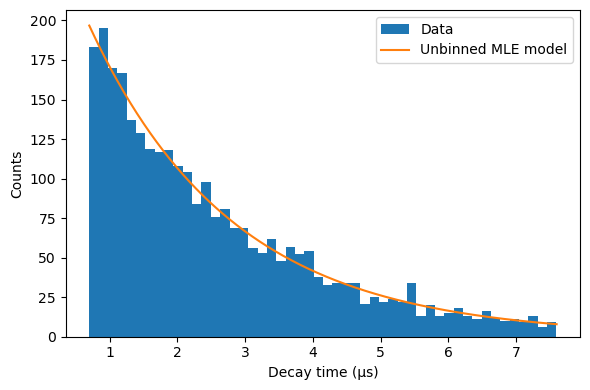

In [22]:
bin_count = 50
t_plot = np.linspace(t_min, t_max, 500)
width = (t_max-t_min) / bin_count
pdf = total_pdf(t_plot, tau_hat, P_hat, t_min, t_max) * len(t_sel) * width # Scale the PDF to be comparable with data
pdf_display(t_plot, pdf, t_sel, bin_count)

Now we have our main measurement of halflife, we must quantify the uncertainty, as without it, it is effectively meaningless. 

To do this we can use likelihood profiling where $\tau$ is fixed to a grid of values, and then $P$ is reoptimised. Then the likelihood can be calculated again, and this difference is used to help quantify the uncertainty. This can be represented mathematically as:

$$\Delta\log\mathcal{L}(\tau) = \log\mathcal{L}(\hat\tau,\hat P) - \max_P\log\mathcal{L}(\tau,P)$$

For one paramater of interest the standard deviation boundary, via Wilk's theorem, is:

$$2 \Delta\log\mathcal{L}(\tau) = 1$$

In [23]:
tau_grid, delta_2nll = likelihood_profiling(tau_hat, P_hat, t_sel, t_min, t_max)
mask = delta_2nll <= 1 # Used to select all values that lie within the confidence region
tau_low = tau_grid[mask][0]
tau_high = tau_grid[mask][-1]

From this uncertainty, the final value for muon lifetime is:

In [24]:
print(f"τ = {tau_hat:.3f} (+{tau_high-tau_hat:.3f} / -{tau_hat-tau_low:.3f}) µs")

τ = 2.118 (+0.067 / -0.094) µs


The final part of this investigation is to validate the model by generating synthetic data, feeding it to the model, and seeing if it can extract the true results. 

In [39]:
tau_true = 2.2
P_true = 0.95

t_toy = generate_toy_data(len(t_sel), tau_true, P_true, t_min, t_max)

tau_rec, P_rec = halflife_estimation(initial_guess, t_toy, t_min, t_max)

print(f"True τ: {tau_true:.3f} µs")
print(f"Recovered τ: {tau_rec:.3f} (+{tau_high-tau_hat:.3f} / -{tau_hat-tau_low:.3f}) µs")



True τ: 2.200 µs
Recovered τ: 2.289 (+0.067 / -0.094) µs


Usually, the recovered lifetime is equal to the true lifetime within statistical uncertainties. 